In [1]:
import numpy as np
from brainiak.reconstruct import iem as IEM
import matplotlib.pyplot as plt
import numpy.matlib as matlib
import scipy.signal

In this example, we will assume that the stimuli are patches of different motion directions. These stimuli span a 360-degree, circular feature space. We will build an encoding model that has 6 channels, or basis functions, which also span this feature space.

In [2]:
# Set up parameters
n_channels = 6
cos_exponent = 5
range_start = 0

range_stop = 360
feature_resolution = 360
iem_obj = IEM.InvertedEncoding1D(n_channels, cos_exponent, stimulus_mode='circular', range_start=range_start, 
                               range_stop=range_stop, channel_density=feature_resolution)

# You can also try the half-circular space. Here's the associated code:
# range_stop = 180  # since 0 and 360 degrees are the same, we want to stop shy of 360
# feature_resolution = 180
# iem_obj = IEM.InvertedEncoding1D(n_channels, cos_exponent, stimulus_mode='halfcircular', range_start=range_start, 
#                                range_stop=range_stop, channel_density=feature_resolution, verbose=True)

stim_vals = np.linspace(0, feature_resolution - (feature_resolution/6), 6).astype(int)

Now we'll generate synthetic data. Ideally, each voxel that we measure from is roughly tuned to some part of the feature space (see Sprague, Boynton, Serences, 2019). So we will generate data that has a receptive field (RF). We can define the RF along the same feature axis as the channels that we generated above.

The following two functions will generate the voxel RFs, and then generate several trials of that dataset. There are options to add uniform noise to either the RF or the trials.

In [3]:
# Generate synthetic data s.t. each voxel has a Gaussian tuning function

def generate_voxel_RFs(n_voxels, feature_resolution, random_tuning=True, RF_noise=0.):
    if random_tuning:
        # Voxel selectivity is random
        voxel_tuning = np.floor((np.random.rand(n_voxels) * range_stop) + range_start).astype(int)
    else:
        # Voxel selectivity is evenly spaced along the feature axis
        voxel_tuning = np.linspace(range_start, range_stop, n_voxels+1)
        voxel_tuning = voxel_tuning[0:-1]
        voxel_tuning = np.floor(voxel_tuning).astype(int)
    gaussian = scipy.signal.gaussian(feature_resolution, 15)
    voxel_RFs = np.zeros((n_voxels, feature_resolution))
    for i in range(0, n_voxels):
        voxel_RFs[i, :] = np.roll(gaussian, voxel_tuning[i] - ((feature_resolution//2)-1))
    voxel_RFs += np.random.rand(n_voxels, feature_resolution)*RF_noise  # add noise to voxel RFs
    voxel_RFs = voxel_RFs / np.max(voxel_RFs, axis=1)[:, None]
    
    return voxel_RFs, voxel_tuning


def generate_voxel_data(voxel_RFs, n_voxels, trial_list, feature_resolution, 
                         trial_noise=0.25):
    one_hot = np.eye(feature_resolution)
    # Generate trial-wise responses based on voxel RFs
    if range_start > 0:
        trial_list = trial_list + range_start
    elif range_start < 0:
        trial_list = trial_list - range_start
    stim_X = one_hot[:, trial_list] #@ basis_set.transpose()
    trial_data = voxel_RFs @ stim_X
    trial_data += np.random.rand(n_voxels, trial_list.size)*(trial_noise*np.max(trial_data))
    
    return trial_data

Now let's generate some training data and look at it. This code will create a plot that depicts the response of an example voxel for different trials.

71.69981024125089


Text(0.5, 0.98, 'Simulated data from each voxel')

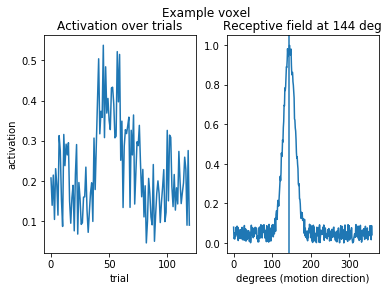

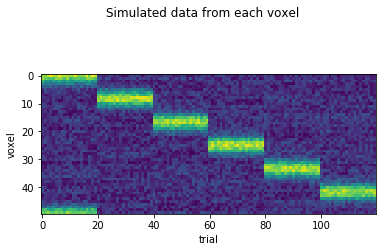

In [4]:
np.random.seed(100)
n_voxels = 50
n_train_trials = 120
training_stim = np.repeat(stim_vals, n_train_trials/6)
voxel_RFs, voxel_tuning = generate_voxel_RFs(n_voxels, feature_resolution, random_tuning=False, RF_noise=0.1)
train_data = generate_voxel_data(voxel_RFs, n_voxels, training_stim, feature_resolution, trial_noise=0.25)
print(np.linalg.cond(train_data))
# print("Voxels are tuned to: ", voxel_tuning)

# Generate plots to look at the RF of an example voxel.
voxi = 20
f = plt.figure()
plt.subplot(1, 2, 1)
plt.plot(train_data[voxi, :])
plt.xlabel("trial")
plt.ylabel("activation")
plt.title("Activation over trials")
plt.subplot(1, 2, 2)
plt.plot(voxel_RFs[voxi, :])
plt.xlabel("degrees (motion direction)")
plt.axvline(voxel_tuning[voxi])
plt.title("Receptive field at {} deg".format(voxel_tuning[voxi]))
plt.suptitle("Example voxel")

plt.figure()
plt.imshow(train_data)
plt.ylabel('voxel')
plt.xlabel('trial')
plt.suptitle('Simulated data from each voxel')

Using this synthetic training data, we can fit the IEM.

In [5]:
# Fit an IEM
iem_obj.fit(train_data.transpose(), training_stim)

Defined channels centered at [  0.  60. 120. 180. 240. 300.] degrees.


InvertedEncoding1D(channel_exp=5, n_channels=6, range_start=0, range_stop=360)

Calling the IEM fit method defines the channels, or the basis set, which span the feature domain. We can examine the channels and plot them to check that they look appropriate.

Remember that the plot below is in circular space. Hence, the channels wrap around the x-axis. For example, the channel depicted in blue is centered at 0 degrees (far left of plot), which is the same as 360 degrees (far right of plot).

We can check whether the channels properly tile the feature space by summing across all of them. This is shown on the right plot. It should be a straight horizontal line.

(6, 360)


Text(0.5, 1.0, 'Sum across channels')

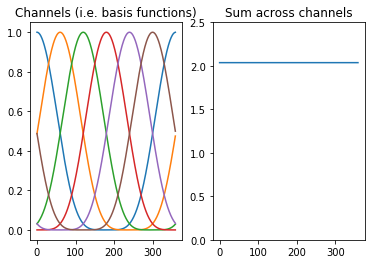

In [6]:
# Let's visualize the basis functions.
channels = iem_obj.channels_
feature_axis = iem_obj.channel_domain
print(channels.shape)

plt.figure()
plt.subplot(1, 2, 1)
for i in range(0, channels.shape[0]):
    plt.plot(feature_axis, channels[i,:])
plt.title('Channels (i.e. basis functions)')
plt.subplot(1, 2, 2)
plt.plot(np.sum(channels, 0))
plt.ylim(0, 2.5)
plt.title('Sum across channels')

Now we can generate test data and see how well we can predict the test stimuli.

In [7]:
# Generate test data
n_test_trials = 12
test_stim = np.repeat(stim_vals, n_test_trials/len(stim_vals))
np.random.seed(330)
test_data = generate_voxel_data(voxel_RFs, n_voxels, test_stim, feature_resolution, trial_noise=0.25)

In [8]:
# Predict test stim & get R^2 score
pred_feature = iem_obj.predict(test_data.transpose())
R2 = iem_obj.score(test_data.transpose(), test_stim)

print("Predicted features are: {} degrees.".format(pred_feature))
print("Actual features are: {} degrees.".format(test_stim))
print("Test R^2 is {}".format(R2))

Predicted features are: [  0.   5.  59.  60. 123. 120. 178. 181. 239. 239. 300. 300.] degrees.
Actual features are: [  0   0  60  60 120 120 180 180 240 240 300 300] degrees.
Test R^2 is 0.9996666666666667


In addition to predicting the exact feature, we can examine the model-based reconstructions in the feature domain. That is, instead of getting single predicted values for each feature, we can look at a reconstructed function which peaks at the predicted feature.

Below we will plot all of the reconstructions. There will be some variability because of the noise added during the synthetic data generation.

Text(0.5, 1.0, 'Reconstructions of [  0  60 120 180 240 300] degrees')

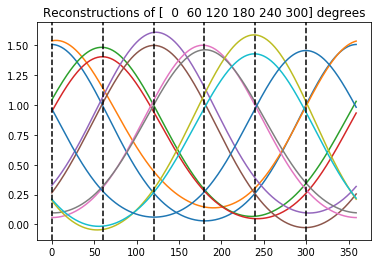

In [9]:
# Now get the model-based reconstructions, which are continuous
# functions that should peak at each test stimulus feature
recons = iem_obj._predict_feature_responses(test_data.transpose())

f = plt.figure()
for i in range(0, n_test_trials-1):
    plt.plot(feature_axis, recons[:, i])
for i in stim_vals:
    plt.axvline(x=i, color='k', linestyle='--')

plt.title("Reconstructions of {} degrees".format(np.unique(test_stim)))

For a sanity check, let's check how R^2 changes as the number of voxels increases. We can write a quick wrapper function to train and test on a given set of motion directions, as below.

In [10]:
iem_obj.verbose = False
def train_and_test(nvox, ntrn, ntst, rfn, tn):
    vRFs, vox_tuning = generate_voxel_RFs(nvox, feature_resolution, random_tuning=True, RF_noise=rfn)
    trn = np.repeat(stim_vals, ntrn/6).astype(int)
    trnd = generate_voxel_data(vRFs, nvox, trn, feature_resolution, trial_noise=tn)
    tst = np.repeat(stim_vals, ntst/6).astype(int)
    tstd = generate_voxel_data(vRFs, nvox, tst, feature_resolution, trial_noise=tn)
    
    iem_obj.fit(trnd.transpose(), trn)
    recons = iem_obj._predict_feature_responses(tstd.transpose())
    pred_ori = iem_obj.predict(tstd.transpose())
    R2 = iem_obj.score(tstd.transpose(), tst)

    return recons, pred_ori, R2, tst

We'll iterate through the list and look at the resulting R^2 values.

In [11]:
np.random.seed(300)
vox_list = (5, 10, 15, 25, 50)
R2_list = np.zeros(len(vox_list))
for idx, nvox in enumerate(vox_list):
    recs, preds, R2_list[idx], test_features = train_and_test(nvox, 120, 30, 0.1, 0.25)

print("The R2 values for increasing numbers of voxels: ")
print(R2_list)

The R2 values for increasing numbers of voxels: 
[0.2661696  0.69445782 0.99524836 0.99806822 0.99877928]
